In [1]:
!pip install biopython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 10.3 MB/s eta 0:00:00


In [2]:
import Bio.PDB as pdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ПОДГОТОВКА

Перейдите на <a href="https://projectswhynot.site/pdb-filtering/">эту страничку</a>, получим ID белков для этого семинара.

In [3]:
path = "filtering_results-3.csv"

data = pd.read_csv(path, ";")

<ipython-input-3-1cdbf297ab47>:3: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  data = pd.read_csv(path, ";")


In [4]:
chains = []

parser = pdb.PDBParser()
for i in range(data.shape[0]):
    pdb_id, model_id, _ = data.loc[i]
    # качаем файл
    path = pdb.PDBList().retrieve_pdb_file(pdb_id,
                                           file_format="pdb")
    # открываем структуру
    struct = parser.get_structure(pdb_id, path)

    chain = struct[model_id].child_list[0].child_list
    chains += [chain]

Structure exists: '/content/hk/pdb1hko.ent' 
Structure exists: '/content/fl/pdb2flj.ent' 


# ЧАСТЬ 1

### Задание 1. Соберите и выведите на гистограмме значения угла $\omega = \angle(C_\alpha^{i-1}, C^{i-1}, N^{i}, C_\alpha^{i})$. Почему он не рассматривается при предсказании геометрии?

In [5]:
omegas = []

for chain in chains:
    for i in range(1, len(chain)):
      try:
        omega = pdb.calc_dihedral(chain[i-1]["CA"].get_vector(),
                                  chain[i-1]["C"].get_vector(),
                                  chain[i]["N"].get_vector(),
                                  chain[i]["CA"].get_vector()
                                  )                             #in radians
        omegas.append(omega)
      except KeyError:
        continue

In [6]:
omegas = []

for chain in chains:
    for i in range(1, len(chain)):
      try:
        omega = pdb.calc_dihedral(chain[i-1]["CA"].get_vector(),
                                  chain[i-1]["C"].get_vector(),
                                  chain[i]["N"].get_vector(),
                                  chain[i]["CA"].get_vector()
                                  ) / np.pi * 180                  #in gradus
        omegas.append(omega)
      except KeyError:
        continue

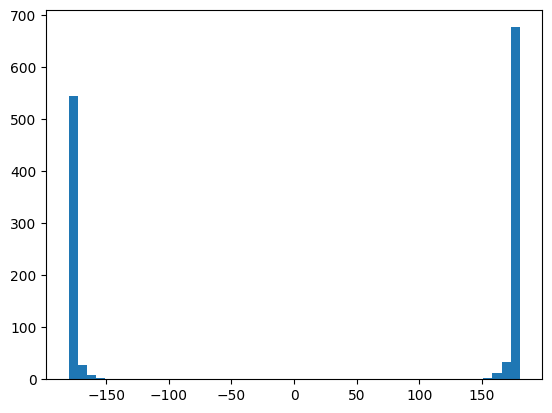

In [7]:
plt.hist(omegas, bins=50)
plt.show()

-3,14 & 3,14 pi <br>
180° & -180° the same <br>
180° in the most case so its doesnt matter <br>

**Угол 𝜔 не рассматривается при предсказании геометрии т.к. он в большинстве случаев равен 180°**


### Задание 2. Выведите отдельно гистограммы значений углов $\phi, \psi$.

In [8]:
phis = []
psis = []

for chain in chains:
    for i in range(1, len(chain) - 1):
      try:
         phi = pdb.calc_dihedral(chain[i-1]["C"].get_vector(),
                                  chain[i]["N"].get_vector(),
                                  chain[i]["CA"].get_vector(),
                                  chain[i]["C"].get_vector()
                                  ) / np.pi * 180
         psi = pdb.calc_dihedral(chain[i]["N"].get_vector(),
                                  chain[i]["CA"].get_vector(),
                                  chain[i]["C"].get_vector(),
                                  chain[i+1]["N"].get_vector()
                                  ) / np.pi * 180
         phis.append(phi)
         psis.append(psi)
      except KeyError:
        continue


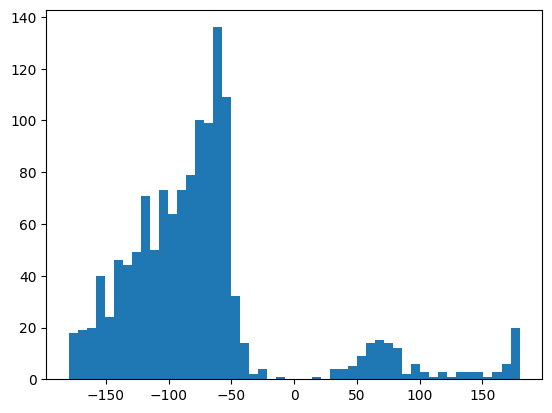

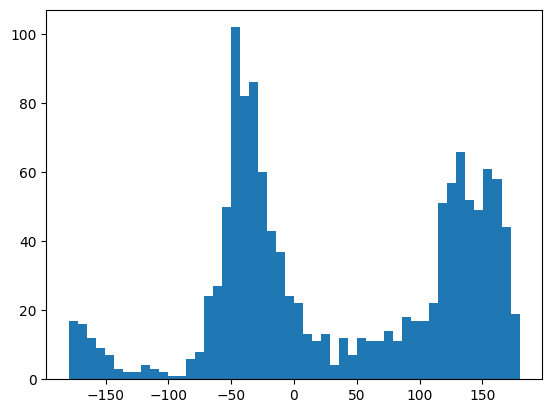

In [9]:
plt.hist(phis, bins=50)
plt.show()

plt.hist(psis, bins=50)
plt.show()

### Задание 3. Постройте карту Рамачандрана для собранных значений. Соотносится ли она с тем, что было рассказано на лекции?

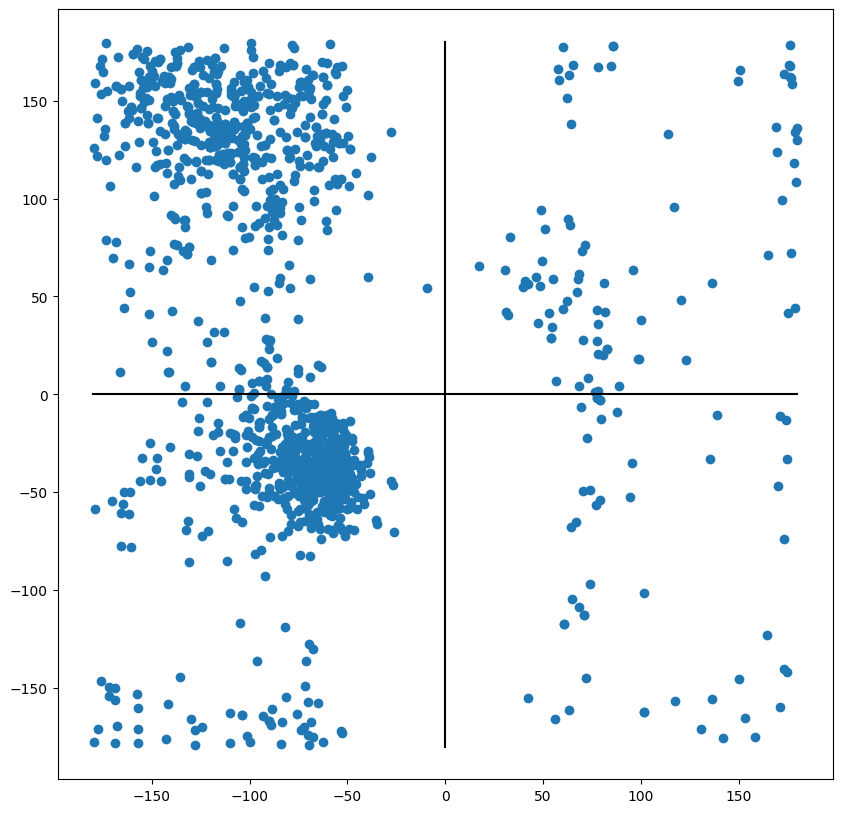

In [10]:
plt.figure(figsize=(10,10))
plt.scatter(phis, psis)

plt.plot([-180,180], [0,0], c = "black")
plt.plot([0,0], [-180,180], c = "black")

plt.axis("equal")
plt.show()

Карта Рамачандрана для собранных значений соотносится тем, что было на лекции, но здесь немного больше значений в правом верхнем и нижнем квадрате (левозакрученная альфа спираль).

# ЧАСТЬ 2

### Допустим, у нас есть основной каркас (все атомы $N,C_\alpha, C$). Давайте восстановим координаты атома $C_\beta$. Для этого нам нужно значение двугранного угла $\angle(C^{i-1}, N^{i}, C_\alpha^{i}, C_\beta^{i})$, значение планарного угла $\angle(N^{i}, C_\alpha^{i}, C_\beta^{i})$ и длина связи $C_\alpha-C_\beta$.

### Задание 4.1. Соберите и выведите на гистограмме значения двугранного угла $\angle(C^{i-1}, N^{i}, C_\alpha^{i}, C_\beta^{i})$. Можно ли визуально заметить зависимость с углами $\phi, \psi?$

**Комментарий:** обратите внимание, у GLY нет атома $C_\beta$!

In [11]:
angles = []

for chain in chains:
    for i in range(1, len(chain)):
      if chain[i].resname == "GLY":
        continue
      try:
         angle = pdb.calc_dihedral(chain[i-1]["C"].get_vector(),
                                  chain[i]["N"].get_vector(),
                                  chain[i]["CA"].get_vector(),
                                  chain[i]["CB"].get_vector()
                                  )
         angles.append(angle)
      except KeyError:
        continue



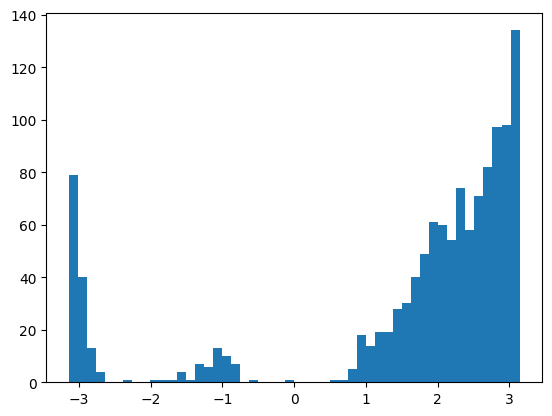

In [12]:
plt.hist(angles, bins=50)
plt.show()

**Можно визуально заметить зависимость с углом 𝜙.**

### Выведите на одном графике значения $\phi$ и $\angle(C^{i-1}, N^{i}, C_\alpha^{i}, C_\beta^{i})$. Восстановите зависимость любым способом.

**Комментарий**: восстановить зависимость = сделать функцию вида **ang_value(phi_value)**!

In [13]:
angles = []
phis = []

for chain in chains:
    for i in range(1, len(chain)):
#      if chain[i].resname == "GLY":
#        continue
     try:
          phi = pdb.calc_dihedral(chain[i-1]["C"].get_vector(),
                                  chain[i]["N"].get_vector(),
                                  chain[i]["CA"].get_vector(),
                                  chain[i]["C"].get_vector()
                                  )
          angle = pdb.calc_dihedral(chain[i-1]["C"].get_vector(),
                                  chain[i]["N"].get_vector(),
                                  chain[i]["CA"].get_vector(),
                                  chain[i]["CB"].get_vector()
                                  )
          angles.append(angle)
          phis.append(phi)
     except KeyError:
      continue


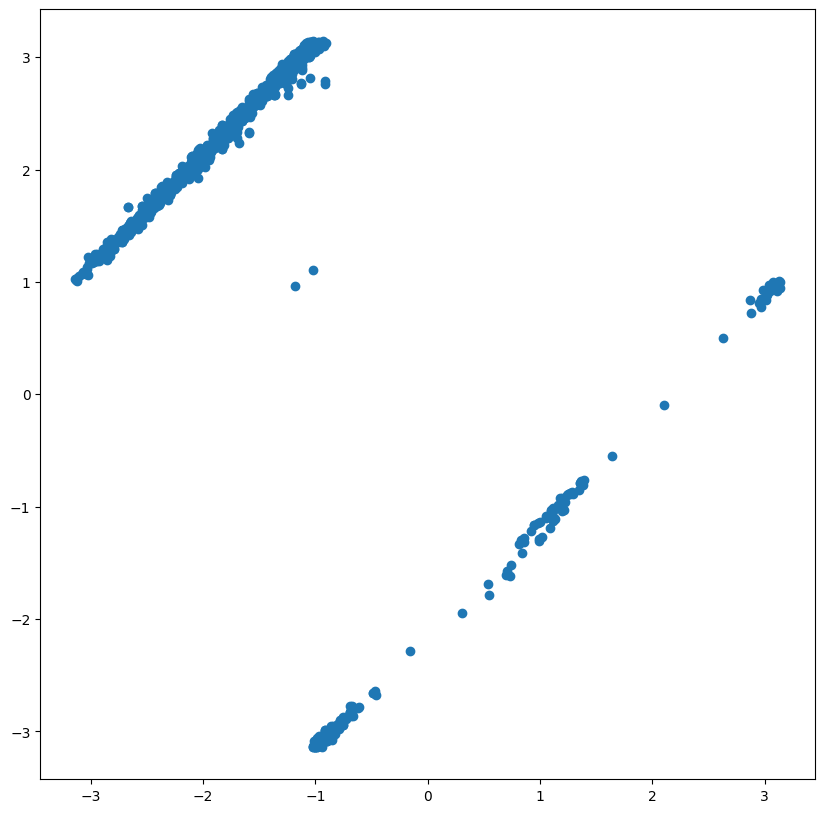

In [14]:
plt.figure(figsize=(10,10))
plt.scatter(phis, angles)

plt.axis("equal")
plt.show()

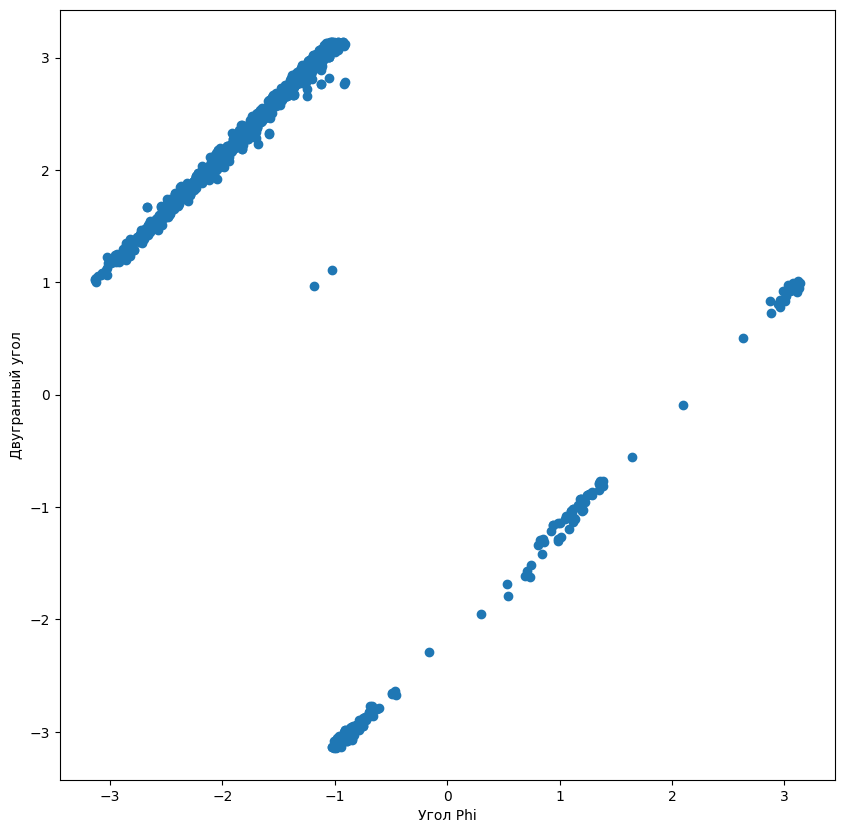

In [15]:
def ang_value(phi_value):
    plt.figure(figsize=(10,10))
    plt.scatter(phi_value, angles)
    plt.xlabel('Угол Phi')
    plt.ylabel('Двугранный угол')
    plt.axis("equal")
    plt.show()


ang_value(phis)

### Задание 4.2. Соберите и выведите на гистограмме значения планарного угла $\angle(N^{i}, C_\alpha^{i}, C_\beta^{i})$. Нужно ли здесь искать зависимость с другими углами или можно просто выбрать какое-то одно значение?

In [16]:
planar_angs = []

for chain in chains:
    for i in range(1, len(chain)):
      try:
        planar_ang = pdb.calc_angle(chain[i]["N"].get_vector(),
                                  chain[i]["CA"].get_vector(),
                                  chain[i]["CB"].get_vector()
                                  )
        planar_angs.append(planar_ang)
      except KeyError:
        continue

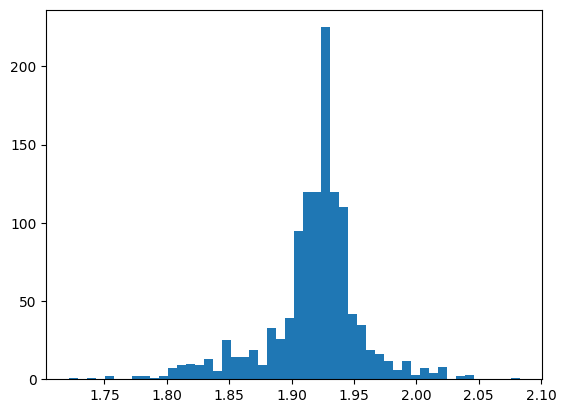

In [17]:
plt.hist(planar_angs, bins=50)
plt.show()

### Задание 4.3. Проведите аналогичное исследование для длины связи $C_\alpha-C_\beta$.

In [18]:
dists = []

for chain in chains:
    for i in range(1, len(chain)):
      try:
        dist = chain[i]["CA"] - chain[i]["CB"]

        dists.append(dist)
      except KeyError:
        continue

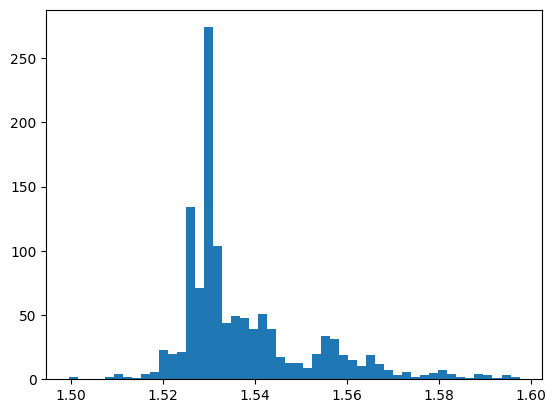

In [19]:
plt.hist(dists, bins=50)
plt.show()

### Задание 5. Теперь у нас все готово для восстановления атомов $C_\beta$. Загрузите <a href=https://disk.yandex.ru/d/QFymCllkjVpKTg>отсюда</a> подготовленный файл; поместите его в папку с ноутбуком и импортируйте все функции из него:

In [20]:
from geometry import *

Используйте функцию place_next_dihedral_atom, чтобы получить координаты следующего атома ($D$) в четверке двугранного угла $A,B,C,D$. Интерфейс запуска:
place_next_dihedral_atom(previous_3_atoms, dihedral_angle_val, planar_angle_val, distance), где:

- previous_3_atoms - np.array размера 3x3, где на каждой строчке записаны координаты соответствующего атома ($A,B,C$);
- dihedral_angle_val - значение двугранного угла $\angle (A-B-C-D)$ (в радианах);
- planar_angle_val - значение планарного угла $\angle (B-C-D)$ (в радианах);
- distance - расстояние $C-D$ (в ангстремах).

Пример запуска:

In [21]:
#prev_coords = np.array([[0,0,0],
#                        [1,0,0],
#                        [2,1,0]])
#dih_ang_val = np.pi/2
#planar_ang_val = np.pi * 3/4
#dist = 3
#next_at = place_next_dihedral_atom(prev_coords, dih_ang_val, planar_ang_val, dist)
#print("Атом D:", next_at)

In [22]:
coordCAs = []

for chain in chains:
    for i in range(1, len(chain)):
      try:
        coordCA = chain[i]["CA"].get_coord()
        coordCAs.append(coordCA)
      except KeyError:
        continue


coordCs = []

for chain in chains:
    for i in range(1, len(chain)):
      try:
        coordC = chain[i-1]["C"].get_coord()
        coordCs.append(coordC)
      except KeyError:
        continue


coordNs = []

for chain in chains:
    for i in range(1, len(chain)):
      try:
        coordN = chain[i]["N"].get_coord()
        coordNs.append(coordN)
      except KeyError:
        continue

In [23]:
print(np.mean(coordCs, axis=0))
print(np.mean(coordNs, axis=0))
print(np.mean(coordCAs, axis=0))

[42.277767   3.508166   3.9569848]
[42.302013   3.4643853  3.913696 ]
[42.29778    3.4986842  3.9510162]


In [24]:
prev_coords = np.array([[42.277767,3.508166,3.9569848],
                        [42.302013,3.4643853,3.913696],
                        [42.29778,3.4986842,3.9510162]])
dih_ang_val = np.mean(angles)
planar_ang_val = np.mean(planar_angs)
dist = np.mean(dist)
next_at = place_next_dihedral_atom(prev_coords, dih_ang_val, planar_ang_val, dist)
print("Атом D:", next_at)

Атом D: [42.07184762  2.79710509  5.27230125]


**Проверка:**

In [25]:
final_dih_ang = pdb.calc_dihedral(pdb.Vector(prev_coords[0]),
                                  pdb.Vector(prev_coords[1]),
                                  pdb.Vector(prev_coords[2]),
                                  pdb.Vector(next_at)
                                 )
print("Получился двугранный угол: {}, а должен быть: {}".format(final_dih_ang, dih_ang_val))

Получился двугранный угол: 1.5946012187653626, а должен быть: 1.5946012187651806


In [26]:
final_plan_ang = pdb.calc_angle(pdb.Vector(prev_coords[1]),
                                pdb.Vector(prev_coords[2]),
                                pdb.Vector(next_at)
                                 )
print("Получился планарный угол: {}, а должен быть: {}".format(final_plan_ang, planar_ang_val))

Получился планарный угол: 1.9182506450769319, а должен быть: 1.9182506450769439


In [27]:
final_bond_len = np.linalg.norm(next_at - prev_coords[2])
print("Получилась длина связи: {}, а должна быть: {}".format(final_bond_len, dist))

Получилась длина связи: 1.5129616260528491, а должна быть: 1.5129616260528564


### С помощью описанной функции предскажите координаты всех $C_\beta$ в тестовом белке с индексом 0. В отдельную переменную сохраните все настоящие координаты $C_\beta$ из белка.

**Напоминание:** У GLY нет $C_\beta$!

In [28]:
chain = chains[0]
cb_preds = []
cb_origs = []


for i in range(1, len(chain)):
  try:
    angle = pdb.calc_dihedral(chain[i-1]["C"].get_vector(),
                             chain[i]["N"].get_vector(),
                             chain[i]["CA"].get_vector(),
                             chain[i]["CB"].get_vector())
    planar_ang = pdb.calc_angle(chain[i]["N"].get_vector(),
                                chain[i]["CA"].get_vector(),
                                chain[i]["CB"].get_vector())
    dist = chain[i]["CA"] - chain[i]["CB"]
    coordC = chain[i-1]["C"].get_coord()
    coordN = chain[i]["N"].get_coord()
    coordCA = chain[i]["CA"].get_coord()
    prev_coords = np.array([coordC,
                            coordN,
                            coordCA])
    cb_pred = place_next_dihedral_atom(prev_coords, angle, planar_ang, dist)
    cb_orig = chain[i]['CB'].get_coord()
    cb_preds.append(cb_pred)
    cb_origs.append(cb_orig)
  except KeyError:
    continue

In [29]:
cb_preds = np.array(cb_preds)

In [30]:
cb_origs = np.array(cb_origs)

### А теперь давайте посмотрим на точность такого восстановления геометрии. Пусть переменная с предсказанными координатами называется $cb\_pred$, с оригинальными - $cb\_orig$.

In [31]:
from Bio.PDB.QCPSuperimposer import QCPSuperimposer

/usr/local/lib/python3.10/dist-packages/Bio/PDB/QCPSuperimposer/__init__.py:24: BiopythonDeprecationWarning: The QCPSuperimposer module will be removed soon in favor of qcprot. The API will remain largely the same.
  warnings.warn(


In [32]:
imposer = QCPSuperimposer()
imposer.set(cb_origs, cb_preds)
imposer.run()
rms = imposer.get_rms()
print("Точность восстановленных CB = {} ангстрем".format(rms))

Точность восстановленных CB = 0.002261045448944884 ангстрем
